# Définition et entrainement des réseaux de neurones
Ce notebook contient les différents modèles que nous avons implémenté et leur performance.

# Imports librairies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
import numpy as np

# Chargement du dataset depuis Google Colab
Les chemins de fichiers sont à modifier selon les besoins.

Commandes pour récupérer le dataset depuis Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# !cp "/content/drive/My Drive/dataASL/data_ASL2.zip" /content/
# !cp "/content/drive/MyDrive/dataASL/data_ASL_test.zip" /content


Commandes pour récupérer le dataset depuis les dossiers de l'ordinateur, en local.

In [ ]:
from google.colab import files
files.upload()

On dézipe les datasets

In [ ]:
# !unzip data_ASL.zip
# !unzip data_ASL_test.zip

Définition des chemins des datasets

In [4]:
dataset_train = "data_ASL_aug"
dataset_test = "data_ASL_test"

# Définition des hyperparamètres

In [14]:
batch_size = 32
learning_rate = 1e-2
epochs = 25

# Modèle 1
Le modèle suivant est un modèle que nous avons trouvé sur Kaggle.
Il fonctionne bien sur les datasets d'entrainement et de test utilisés par l'auteur. Cependant il ne donne pas de bon résultat lorsque nous l'utilisons sur d'autres datasets.

Description du modèle:

* Prends en entrée une image 200x200x3 (car image en couleur)
*   **Convolution** : Applique 16 filtres de convolution 2D de taille 5×5.
*   **Fonction d'activation ReLU**
* **Max pooling** de taille 2x2
* **Convulation** : Applique 32 filtres de convolution 2D de taille 5×5.
*   **Fonction d'activation ReLU**
* **Max pooling** de taille 2x2
* **Convolution** : Applique 64 filtres de convolution 2D de taille 5×5.
* **Fonction d'activation ReLU**
* **Max pooling** de taille 2x2
* **Dropout** : Désactive aléatoirement 20% des neurones pour éviter l'overfitting.
* **Flattening**
* **Couche dense** (linéaire)
* **Fonction d'activation ReLU**
* **Couche dense** (linéaire)

Hyper-paramètres utilisés:
* **Batch-size**: 32 ➡ Déterminer après plusieurs essaient, en essayant de l'augmenter, nous avons remarqué que le modèle n'arrivait pas à apprendre.
* **Learning rate**: 10e-3  ➡ Déterminer après plusieurs essaient, en essayant de le réduire, nous avons remarqué que le modèle n'arrivait pas à apprendre.
* **Epoques**: 25 ➡ Le nombre d'époques ne paraissaient pas important dans ce modèle puisque qu'au bout d'une dizaine d'époque il commence à overfitter (ne plus s'améliorer sur le dataset de validation).


📈 Après 25 époques, le modèle semble bien apprendre sur les données d'entraînement, avec une précision qui atteint environ 97% à la fin de cette dernière époque. Cependant, la précision sur les données de validation se stabilise autour de 60-62% à partir de la 4ième époque, ce qui suggère que le modèle overfit.


💻 Sur notre dataset de test, nous n'obtenons sur ce modèle pas les résultats attendus, avec seulement 26.32% de données bien classées. Nous nous attendions à mieux que 26.32% puisque le modèle a été trouvé sur Kaggle.


https://www.kaggle.com/code/ahmedhussien710/sign-language-from-images-using-torch

CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_train, transform=transform)


train_size = int(0.8 * len(dataset))
test_size =  len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print("Training batch shape:", train_images.shape)
print("Testing batch shape:", test_images.shape)

class_names = dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)
print(num_classes)

Total samples: 41520
Training samples: 33216
Testing samples: 8304
Training batch shape: torch.Size([32, 3, 200, 200])
Testing batch shape: torch.Size([32, 3, 200, 200])
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'vide']
27


Création des dictionnaires pour associer des classes à des labels et vice-versa.

In [ ]:
class_to_label = {class_name: idx for idx, class_name in enumerate(dataset.classes)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

print("Class-to-Label Mapping:", class_to_label)
print("Label-to-Class Mapping:", label_to_class)

Class-to-Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'vide': 26}
Label-to-Class Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'vide'}


Définition des couches du réseau

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5), #output_shape=(batch_size, 16, 196, 196)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 16, 98, 98)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5), #output_shape=(batch_size, 32, 94, 94)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 32, 47, 47)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), #output_shape=(batch_size, 64, 43, 43)
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5), #output_shape=(batch_size, 128, 39, 39)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #output_shape=(batch_size, 128, 19, 19)
            nn.Dropout(p=0.2),
            nn.Flatten(),
            nn.Linear(128 * 19 * 19, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        logits = self.convolution(x)
        return logits

In [ ]:
model = ImageClassifier(num_classes=num_classes).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Défintions des boucles d'entrainement et de test:

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses_list = []
    train_total_correct = 0
    train_total_samples = 0

    model.train()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_list.append(loss.item())

        train_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = sum(train_losses_list) / len(train_losses_list)
    avg_train_acc = train_total_correct / len(dataloader.dataset)

    return avg_train_loss, avg_train_acc

In [ ]:
def test_loop(dataloader, model, loss_fn):

    test_losses_list = []
    test_total_correct = 0
    test_total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device=device, dtype=torch.long)

            pred = model(x)
            loss = loss_fn(pred, y)

            test_losses_list.append(loss.item())

            test_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = sum(test_losses_list) / len(test_losses_list)
    avg_test_acc = test_total_correct / len(dataloader.dataset)
    return avg_test_loss, avg_test_acc

Entrainement du modèle

In [ ]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    start = time.time()
    avg_train_loss, avg_train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    avg_test_loss, avg_test_acc = test_loop(test_loader, model, loss_fn)


    train_acc_list.append(avg_train_acc)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(avg_test_loss)

    print(f"Epoch: {epoch+1}/{epochs} - {round(time.time()-start)}s - Training accuracy: {avg_train_acc:.4f} - Training loss: {avg_train_loss:.4f} - Test accuracy: {avg_test_acc:.2f} - Test loss: {avg_test_loss:.2f}")

Epoch: 1/25 - 88s - Training accuracy: 0.1099 - Training loss: 3.0795 - Test accuracy: 0.25 - Test loss: 2.61
Epoch: 2/25 - 82s - Training accuracy: 0.3877 - Training loss: 2.1412 - Test accuracy: 0.49 - Test loss: 1.81
Epoch: 3/25 - 82s - Training accuracy: 0.5972 - Training loss: 1.4229 - Test accuracy: 0.56 - Test loss: 1.61
Epoch: 4/25 - 82s - Training accuracy: 0.7198 - Training loss: 0.9736 - Test accuracy: 0.59 - Test loss: 1.60
Epoch: 5/25 - 84s - Training accuracy: 0.8036 - Training loss: 0.6650 - Test accuracy: 0.60 - Test loss: 1.74
Epoch: 6/25 - 84s - Training accuracy: 0.8583 - Training loss: 0.4582 - Test accuracy: 0.60 - Test loss: 1.92
Epoch: 7/25 - 82s - Training accuracy: 0.8920 - Training loss: 0.3419 - Test accuracy: 0.60 - Test loss: 2.18
Epoch: 8/25 - 82s - Training accuracy: 0.9163 - Training loss: 0.2641 - Test accuracy: 0.59 - Test loss: 2.51
Epoch: 9/25 - 82s - Training accuracy: 0.9284 - Training loss: 0.2225 - Test accuracy: 0.60 - Test loss: 2.71
Epoch: 10/

Courbes de l'accuracy et de la loss:

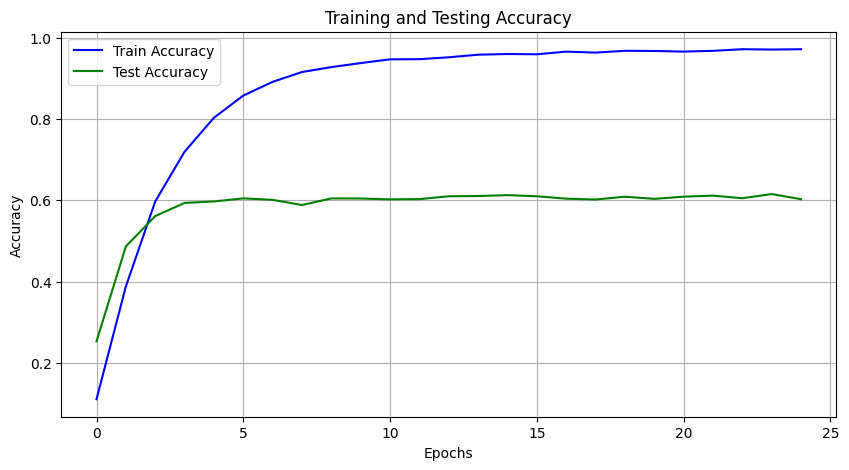

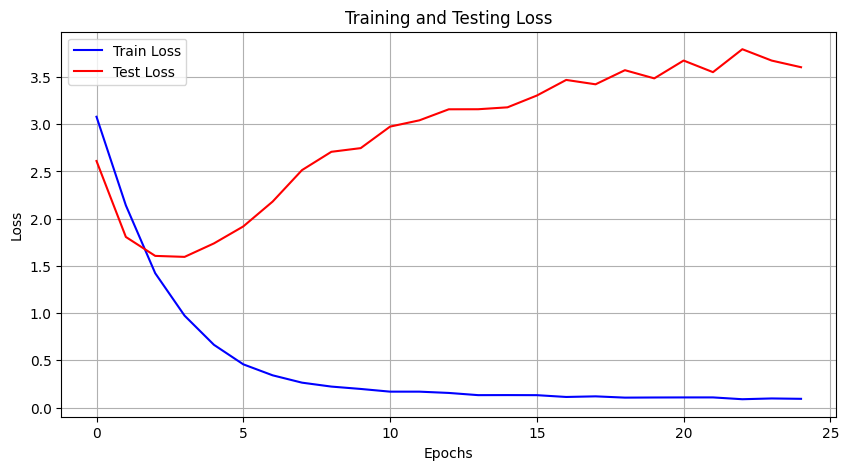

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc_list, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_acc_list, label="Test Accuracy", color='green')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss_list, label="Train Loss", color='blue')
plt.plot(range(epochs), test_loss_list, label="Test Loss", color='red')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Prédiction sur les data test:

In [ ]:
true_classes = []
val_images = []
for dirname, _ , filenames in os.walk(dataset_test):
    for filename in filenames:
      true_classes.append(os.path.basename(dirname))

      path=os.path.join(dirname, filename)
      img = Image.open(path)
      img_tensor = transform(img)
      val_images.append(img_tensor)
val_dataset = torch.stack(val_images)

In [ ]:
model.eval()
with torch.no_grad():
    output = model(val_dataset.to(device))
output = output.cpu()
pred_labels = output.argmax(1).numpy()

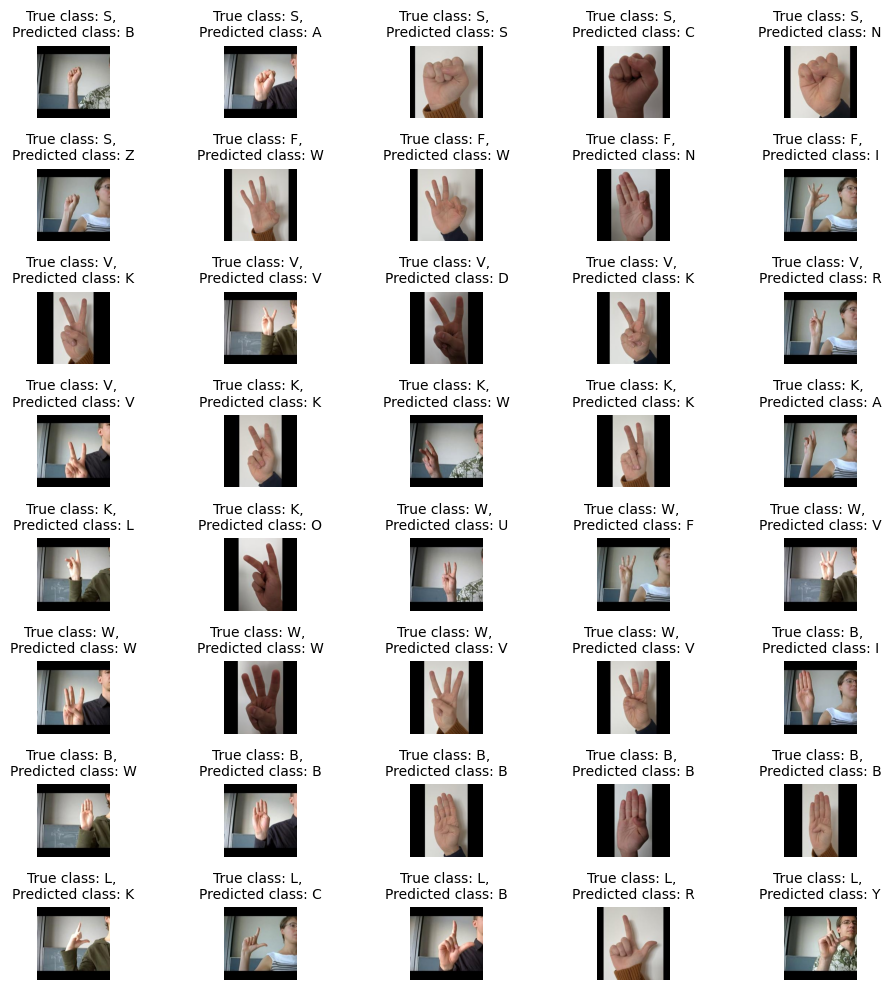

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0, 40):
    plt.subplot(8, 5, i+1)

    plt.imshow(np.transpose(val_images[i].numpy(), (1, 2, 0)))
    plt.title(f"True class: {true_classes[i]}, \nPredicted class: {label_to_class[pred_labels[i]]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
nb_vrai = 0
nb_faux = 0
for i in range(0, len(pred_labels)):
  if true_classes[i] == label_to_class[pred_labels[i]]:
    nb_vrai += 1
  else:
    nb_faux += 1

print(f"Nombre de prédictions bonnes: {nb_vrai}")
print(f"Nombre de fausses: {nb_faux}")
print(f"Pourcentage de bonnes prédictions: {round(nb_vrai/len(pred_labels)*100, 2)}%")

Nombre de prédictions bonnes: 41
Nombre de fausses: 111
Pourcentage de bonnes prédictions: 26.97%


# Modèle 2
Ce modèle a été réalisé par nos soins. Nous avons essayer de faire en CNN simple mais malheureusement ce dernier overfit. Cela peut etre du au fait que notre datasets ne contient pas assez de d'images.

Description du modèle:
* Prend en entrée une image 200x200x3 (image en couleur)
* **Convolution**: Applique 32 filtres de convolution 2D de taille 3×3 avec padding 1
* **Fonction d'activation ReLU**
* **Max pooling** de taille 2×2
* **Convolution** : Applique 64 filtres de convolution 2D de taille 3×3 avec padding 1
* Fonction d'activation ReLU
* **Max pooling** de taille 2×2
* **Convolution** : Applique 128 filtres de convolution 2D de taille 3×3 avec padding 1
* **Fonction d'activation ReLU**
* Max pooling de taille 2×2
* **Flattening** : Transforme l'entrée 3D en vecteur 1D
* **Couche dense** (linéaire) : 512 neurones
* **Fonction d'activation ReLU**
* **Couche dense (linéaire)** : Nombre de sorties égal au nombre de classes

Hyper-paramètres utilisés:
* **Batch-size**: 32 ➡ Déterminer après plusieurs essaient, en essayant de l'augmenter, nous avons remarqué que le modèle n'arrivait pas à apprendre.
* **Learning rate**: 10e-3  ➡ Déterminer après plusieurs essaient, en essayant de le réduire, nous avons remarqué que le modèle n'arrivait pas à apprendre.
* **Epoques**: 25 ➡ Le nombre d'époques ne paraissaient pas important dans ce modèle puisque qu'au bout d'une dizaine d'époque il commence à overfitter (ne plus s'améliorer sur le dataset de validation).
* **Dropout**: 0.5 ➡ On a utilisé le dropout pour essayer de faire un sorte que le modèle overfit moins, cependant meme en l'augmentant cela n'a pas résolu notre problème, c'est pour cela que nous sommes resté sur 0.5 et pas plus.

💡**Pourquoi tester un tel modèle**: après avoir vu que le premier modèle overfittait, nous avons voulu créer un modèle plus simple. En effet, un modèle simple est moins enclin à overfitter qu'un modèle complexe puisqu'on le force à se concentrer sur les caractéristiques les plus importantes des données.

📈 Après 25 époques, le modèle semble bien apprendre sur les données d'entraînement, avec une précision qui atteint environ 99% à la fin de cette dernière époque. Cependant, la précision sur les données de validation se stabilise autour de 59-61% à partir de la 3ième époque, ce qui suggère que le modèle overfit.


💻 Sur notre dataset de test, nous n'obtenons sur ce modèle pas les résultats attendus, avec seulement 23.03% de données bien classées. Ce qui est loin d'etre correct mais que montre quand meme qui notre modèle a appris puisque qu'une prédiction au hasard, la prédiction serait bonne, uniquement 3.7% (=1/27 avec 27 le nombre de classes) des fois.

🖊 Il est quand meme important de noter que parfois notre modèle se trompe à peu de chose près, par exemple il prédit un F au lieu d'un B, alors que ces lettres ne différent que par un unique doigt levé.

CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=dataset_train, transform=transform)


train_size = int(0.8 * len(dataset))
test_size =  len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print("Training batch shape:", train_images.shape)
print("Testing batch shape:", test_images.shape)

class_names = dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)
print(num_classes)

Total samples: 41520
Training samples: 33216
Testing samples: 8304
Training batch shape: torch.Size([32, 3, 200, 200])
Testing batch shape: torch.Size([32, 3, 200, 200])
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'vide']
27


Création des dictionnaires pour associer des classes à des labels et vice-versa.

In [ ]:
class_to_label = {class_name: idx for idx, class_name in enumerate(dataset.classes)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

print("Class-to-Label Mapping:", class_to_label)
print("Label-to-Class Mapping:", label_to_class)

Class-to-Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'vide': 26}
Label-to-Class Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'vide'}


Définition des couches du réseau

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Couches de convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Couche de Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 25 * 25, 512)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
model = ImageClassifier(num_classes=num_classes).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Définitions des boucles d'entrainement et de test:

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses_list = []
    train_total_correct = 0
    train_total_samples = 0

    model.train()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_list.append(loss.item())

        train_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = sum(train_losses_list) / len(train_losses_list)
    avg_train_acc = train_total_correct / len(dataloader.dataset)

    return avg_train_loss, avg_train_acc

In [ ]:
def test_loop(dataloader, model, loss_fn):

    test_losses_list = []
    test_total_correct = 0
    test_total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device=device, dtype=torch.long)

            pred = model(x)
            loss = loss_fn(pred, y)

            test_losses_list.append(loss.item())

            test_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = sum(test_losses_list) / len(test_losses_list)
    avg_test_acc = test_total_correct / len(dataloader.dataset)
    return avg_test_loss, avg_test_acc

Entrainement du modèle

In [ ]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    start = time.time()
    avg_train_loss, avg_train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    avg_test_loss, avg_test_acc = test_loop(test_loader, model, loss_fn)


    train_acc_list.append(avg_train_acc)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(avg_test_loss)

    print(f"Epoch: {epoch+1}/{epochs} - {round(time.time()-start)}s - Training accuracy: {avg_train_acc:.4f} - Training loss: {avg_train_loss:.4f} - Test accuracy: {avg_test_acc:.2f} - Test loss: {avg_test_loss:.2f}")

Epoch: 1/25 - 103s - Training accuracy: 0.1861 - Training loss: 2.8290 - Test accuracy: 0.37 - Test loss: 2.22
Epoch: 2/25 - 99s - Training accuracy: 0.5380 - Training loss: 1.6297 - Test accuracy: 0.56 - Test loss: 1.61
Epoch: 3/25 - 99s - Training accuracy: 0.7622 - Training loss: 0.8272 - Test accuracy: 0.59 - Test loss: 1.66
Epoch: 4/25 - 100s - Training accuracy: 0.9039 - Training loss: 0.3144 - Test accuracy: 0.60 - Test loss: 1.95
Epoch: 5/25 - 99s - Training accuracy: 0.9575 - Training loss: 0.1361 - Test accuracy: 0.57 - Test loss: 2.61
Epoch: 6/25 - 100s - Training accuracy: 0.9686 - Training loss: 0.1041 - Test accuracy: 0.60 - Test loss: 2.88
Epoch: 7/25 - 99s - Training accuracy: 0.9744 - Training loss: 0.0828 - Test accuracy: 0.59 - Test loss: 3.22
Epoch: 8/25 - 100s - Training accuracy: 0.9760 - Training loss: 0.0784 - Test accuracy: 0.59 - Test loss: 3.48
Epoch: 9/25 - 100s - Training accuracy: 0.9785 - Training loss: 0.0712 - Test accuracy: 0.58 - Test loss: 3.47
Epoch

Courbes de l'accuracy et de la loss:

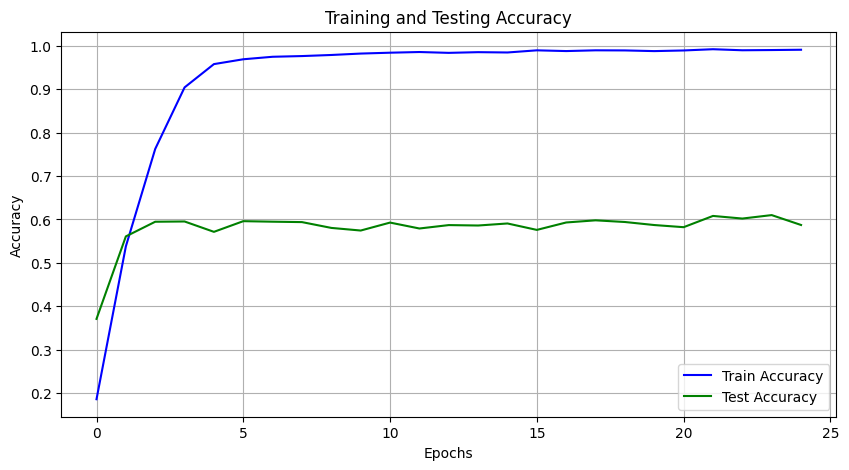

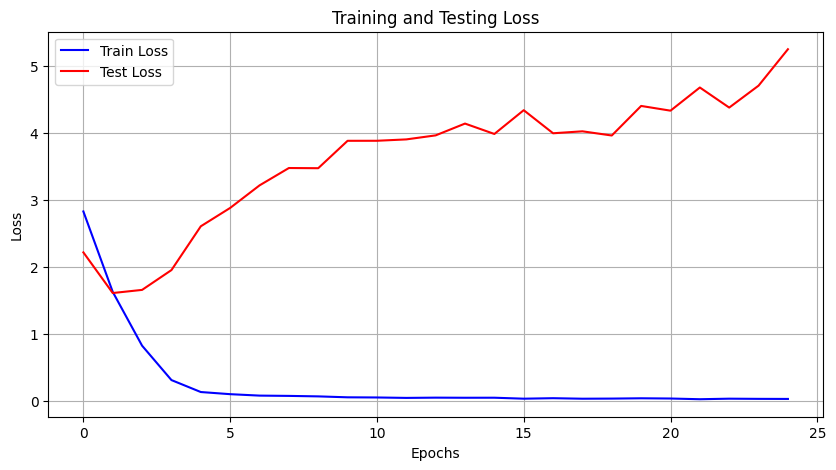

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc_list, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_acc_list, label="Test Accuracy", color='green')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss_list, label="Train Loss", color='blue')
plt.plot(range(epochs), test_loss_list, label="Test Loss", color='red')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Résultats sur les données test:

In [ ]:
true_classes = []
val_images = []
for dirname, _ , filenames in os.walk(dataset_test):
    for filename in filenames:
      if filename != 'dataset/ASL_Dataset/Test':
        true_classes.append(os.path.basename(dirname))

        path=os.path.join(dirname, filename)
        img = Image.open(path)
        img_tensor = transform(img)
        val_images.append(img_tensor)
val_dataset = torch.stack(val_images)

In [ ]:
model.eval()
with torch.no_grad():
    output = model(val_dataset.to(device))
output = output.cpu()
pred_labels = output.argmax(1).numpy()

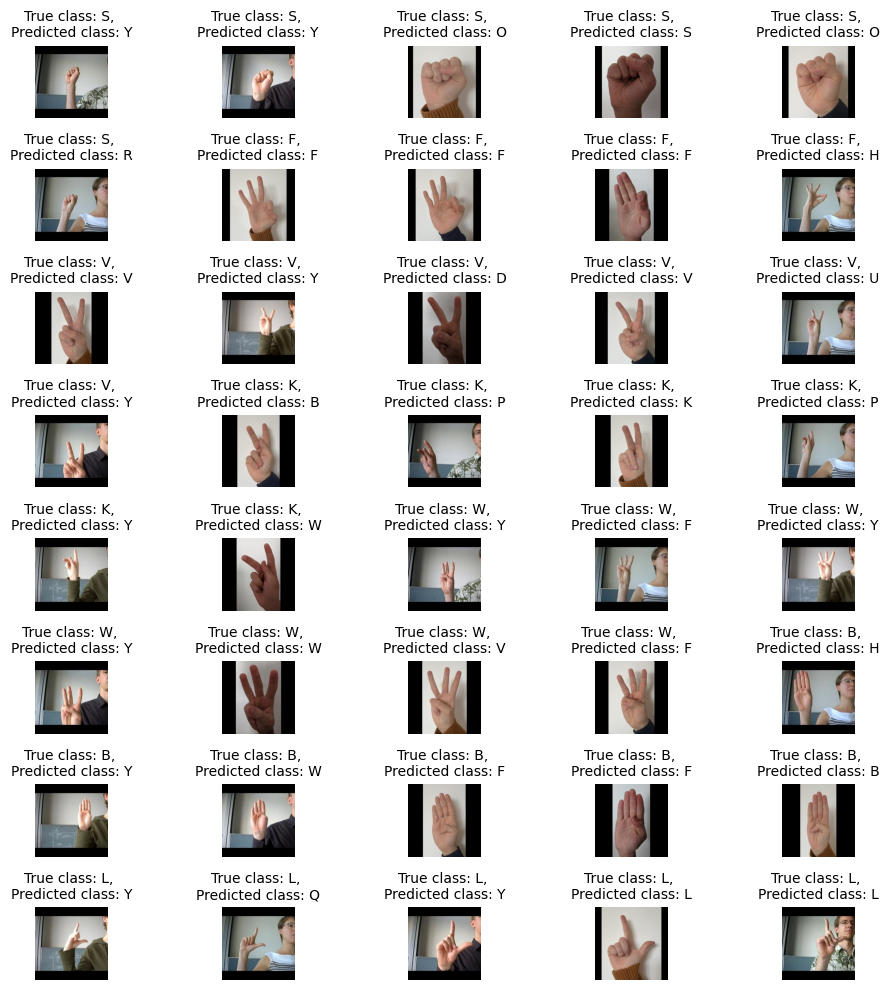

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0, 40):
    plt.subplot(8, 5, i+1)

    plt.imshow(np.transpose(val_images[i].numpy(), (1, 2, 0)))
    plt.title(f"True class: {true_classes[i]}, \nPredicted class: {label_to_class[pred_labels[i]]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
nb_vrai = 0
nb_faux = 0
for i in range(0, len(pred_labels)):
  if true_classes[i] == label_to_class[pred_labels[i]]:
    nb_vrai += 1
  else:
    nb_faux += 1

print(f"Nombre de prédictions bonnes: {nb_vrai}")
print(f"Nombre de fausses: {nb_faux}")
print(f"Pourcentage de bonnes prédictions: {round(nb_vrai/len(pred_labels)*100, 2)}%")

Nombre de prédictions bonnes: 35
Nombre de fausses: 117
Pourcentage de bonnes prédictions: 23.03%


# Modèle 3
Le modèle suivant est inspiré du modèle VGG16 mais adapté pour des images 200x200x3 contre 224x224x3.

En effet, il est composé:

*   de noyau de convolution de taille 3×3
*   de couche de Max-Pooling de taille 2×2
*   d'une augmentation progressive des canaux convolutifs (64 → 128 → 256).

Description du modèle:
* Prend en entrée une image 200x200x**1** (image avec un seul canal de couleur)
* **Convolution**: Applique 64 filtres de convolution 2D de taille 3×3 avec padding 1
* **Fonction d'activation ReLU**
* **Convolution** : Applique 64 filtres de convolution 2D de taille 3×3 avec padding 1
* **Fonction d'activation ReLU**
* **Max pooling** de taille 2×2 et stride de 2
* **Convolution** : Applique 128 filtres de convolution 2D de taille 3×3 avec padding 1
* **Fonction d'activation ReLU**
* **Max pooling** de taille 2×2 et stride de 2
* **Flattening** : Transforme l'entrée 3D en vecteur 1D
* **Couche dense** (linéaire) : 256 neurones
* **Dropout**: 0.5
* **Couche dense (linéaire)** : Nombre de sorties égal au nombre de classes


Hyper-paramètres utilisés:
* **Batch-size**: 64 ➡ Déterminer après avoir essayer une taille de 32 qui ne fonctionnait pas et empecher le modèle d'apprendre.
* **Learning rate**: 10e-3  ➡ Déterminer après plusieurs essaient, en essayant de le réduire, nous avons remarqué que le modèle n'arrivait pas à apprendre.
* **Epoques**: 25 ➡ Le nombre d'époques ne paraissaient pas important dans ce modèle puisque qu'au bout d'une dizaine d'époque il commence à overfitter (ne plus s'améliorer sur le dataset de validation).
* **Dropout**: 0.5 ➡ On a utilisé le dropout pour essayer de faire un sorte que le modèle overfit moins, cependant meme en l'augmentant cela n'a pas résolu notre problème, c'est pour cela que nous sommes resté sur 0.5 et pas plus.


💡**Pourquoi tester un tel modèle**:

📈 Après 25 époques, le modèle semble bien apprendre sur les données d'entraînement, avec une précision qui atteint environ 93% à la fin de cette dernière époque. Cependant, la précision sur les données de validation se stabilise autour de 49% à partir de la 8ième époque, ce qui suggère que le modèle overfit.


💻 Sur notre dataset de test, nous n'obtenons sur ce modèle clairement pas les résultats attendus, avec seulement 23.03% de données bien classées. Ce qui est loin d'etre correct mais qui montre quand meme que notre modèle a appris puisque qu'une prédiction au hasard, la prédiction serait bonne, uniquement 3.7% (=1/27 avec 27 le nombre de classes) des fois.


🖊 Nous avons voulu sur ce modèle tester l'apprentissage sur une image monochrome pour voir si l'apprentissage n'était pas biaisé par les différentes couleurs des mains. Cependant au vu des résultats décevants cela n'est pas le cas.




CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertit l'image en noir et blanc
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalise pour le noir et blanc
])

# transform = transforms.Compose([
#     transforms.Resize((200, 200)),
#     transforms.ToTensor(),
# ])


dataset = datasets.ImageFolder(root=dataset_train, transform=transform)


train_size = int(0.8 * len(dataset))
test_size =  len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print("Training batch shape:", train_images.shape)
print("Testing batch shape:", test_images.shape)

class_names = dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)
print(num_classes)

Total samples: 41520
Training samples: 33216
Testing samples: 8304
Training batch shape: torch.Size([64, 1, 200, 200])
Testing batch shape: torch.Size([64, 1, 200, 200])
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'vide']
27


Création des dictionnaires pour associer des classes à des labels et vice-versa.

In [ ]:
class_to_label = {class_name: idx for idx, class_name in enumerate(dataset.classes)}
label_to_class = {idx: class_name for class_name, idx in class_to_label.items()}

print("Class-to-Label Mapping:", class_to_label)
print("Label-to-Class Mapping:", label_to_class)

Class-to-Label Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'vide': 26}
Label-to-Class Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'vide'}


Définition des couches du réseau

In [24]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Pour rgb: 1 --> 3
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 50 * 50, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 27)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
model = ImageClassifier(num_classes=num_classes).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Défintions des boucles d'entrainement et de test:

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses_list = []
    train_total_correct = 0
    train_total_samples = 0

    model.train()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)

        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses_list.append(loss.item())

        train_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = sum(train_losses_list) / len(train_losses_list)
    avg_train_acc = train_total_correct / len(dataloader.dataset)

    return avg_train_loss, avg_train_acc

In [ ]:
def test_loop(dataloader, model, loss_fn):

    test_losses_list = []
    test_total_correct = 0
    test_total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device=device, dtype=torch.long)

            pred = model(x)
            loss = loss_fn(pred, y)

            test_losses_list.append(loss.item())

            test_total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = sum(test_losses_list) / len(test_losses_list)
    avg_test_acc = test_total_correct / len(dataloader.dataset)
    return avg_test_loss, avg_test_acc

Entrainement du modèle

In [ ]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    start = time.time()
    avg_train_loss, avg_train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    avg_test_loss, avg_test_acc = test_loop(test_loader, model, loss_fn)


    train_acc_list.append(avg_train_acc)
    test_acc_list.append(avg_test_acc)
    train_loss_list.append(avg_train_loss)
    test_loss_list.append(avg_test_loss)

    print(f"Epoch: {epoch+1}/{epochs} - {round(time.time()-start)}s - Training accuracy: {avg_train_acc:.4f} - Training loss: {avg_train_loss:.4f} - Test accuracy: {avg_test_acc:.2f} - Test loss: {avg_test_loss:.2f}")

Epoch: 1/25 - 249s - Training accuracy: 0.0680 - Training loss: 3.2272 - Test accuracy: 0.16 - Test loss: 3.02
Epoch: 2/25 - 249s - Training accuracy: 0.2250 - Training loss: 2.7121 - Test accuracy: 0.33 - Test loss: 2.39
Epoch: 3/25 - 249s - Training accuracy: 0.3655 - Training loss: 2.1934 - Test accuracy: 0.42 - Test loss: 2.08
Epoch: 4/25 - 249s - Training accuracy: 0.4883 - Training loss: 1.7427 - Test accuracy: 0.45 - Test loss: 1.97
Epoch: 5/25 - 248s - Training accuracy: 0.6039 - Training loss: 1.3181 - Test accuracy: 0.47 - Test loss: 1.98
Epoch: 6/25 - 249s - Training accuracy: 0.6967 - Training loss: 0.9863 - Test accuracy: 0.48 - Test loss: 2.10
Epoch: 7/25 - 248s - Training accuracy: 0.7562 - Training loss: 0.7712 - Test accuracy: 0.48 - Test loss: 2.19
Epoch: 8/25 - 248s - Training accuracy: 0.8044 - Training loss: 0.6156 - Test accuracy: 0.49 - Test loss: 2.34
Epoch: 9/25 - 248s - Training accuracy: 0.8299 - Training loss: 0.5259 - Test accuracy: 0.48 - Test loss: 2.34
E

Courbes de l'accuracy et de la loss:

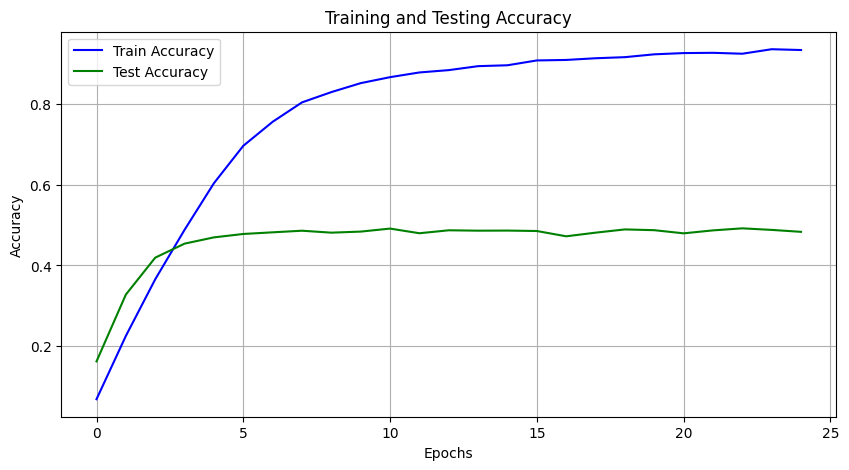

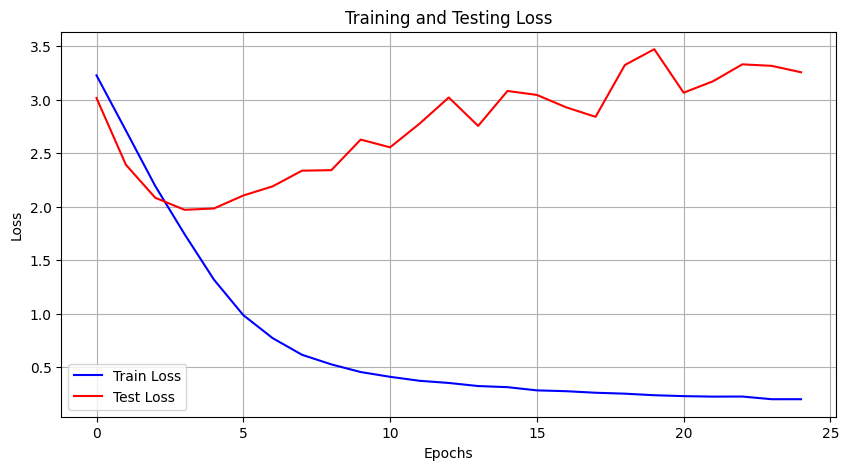

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_acc_list, label="Train Accuracy", color='blue')
plt.plot(range(epochs), test_acc_list, label="Test Accuracy", color='green')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_loss_list, label="Train Loss", color='blue')
plt.plot(range(epochs), test_loss_list, label="Test Loss", color='red')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Prédiction sur le dataset test

In [ ]:
true_classes = []
val_images = []
for dirname, _ , filenames in os.walk(dataset_test):
    for filename in filenames:
      true_classes.append(os.path.basename(dirname))

      path=os.path.join(dirname, filename)
      img = Image.open(path)
      img_tensor = transform(img)
      val_images.append(img_tensor)
val_dataset = torch.stack(val_images)

In [ ]:
model.eval()
with torch.no_grad():
    output = model(val_dataset.to(device))
output = output.cpu()
pred_labels = output.argmax(1).numpy()

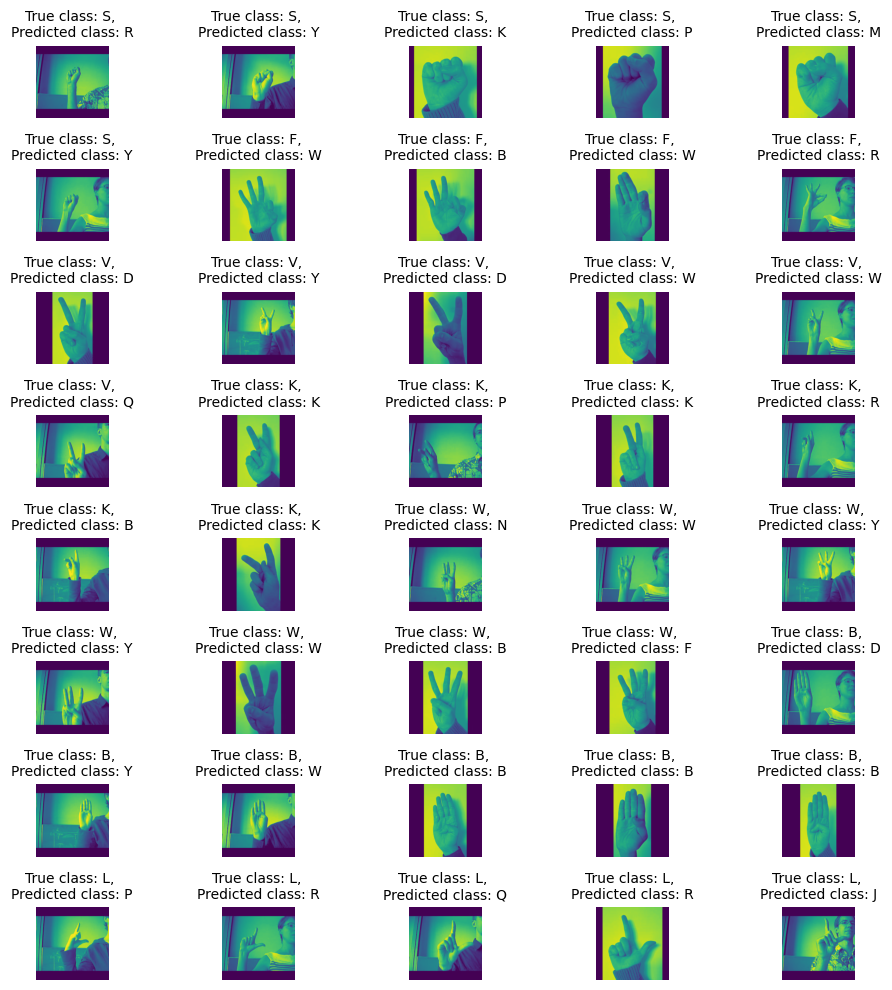

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(0, 40):
    plt.subplot(8, 5, i+1)

    plt.imshow(np.transpose(val_images[i].numpy(), (1, 2, 0)))
    plt.title(f"True class: {true_classes[i]}, \nPredicted class: {label_to_class[pred_labels[i]]}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
nb_vrai = 0
nb_faux = 0
for i in range(0, len(pred_labels)):
  if true_classes[i] == label_to_class[pred_labels[i]]:
    nb_vrai += 1
  else:
    nb_faux += 1

print(f"Nombre de prédictions bonnes: {nb_vrai}")
print(f"Nombre de fausses: {nb_faux}")
print(f"Pourcentage de bonnes prédictions: {round(nb_vrai/len(pred_labels)*100, 2)}%")

Nombre de prédictions bonnes: 26
Nombre de fausses: 126
Pourcentage de bonnes prédictions: 17.11%


# Sauvegarde du modèle

In [ ]:
torch.save({
   'epoch': epoch,
   'model_state_dict': model.state_dict(),
   'optimizer_state_dict': optimizer.state_dict(),
   'loss': avg_train_loss,
}, 'full_model3.pth')

# Conclusion
Les résultats sur les modèles implémentés et présentés sont loin d'etre concluants. Ils traduisent tous un phénomène d'overfitting. Phénomène résultant peut etre du fait que le dataset d'entrainement que nous avons créé n'était pas assez diversifié et pas assez grand.

Cependant, il est important de noter que bien que les resultats aient été peu concluant, les prédictions faites se rapprochent souvent d'un signe assez similaire. Nos modèles ont donc bien appris des caractéristiques clés des divers signes de la langue des signes américaine.